# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- <b>Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.</b>

In [1]:
import json
import pandas as pd
import numpy as np
from utils import *
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import GridSearchCV
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

In [4]:
for championship in events_df:
    if (championship == 'European_Championship') or (championship == 'World_Cup'):
        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']
    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)
    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)
    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True)

In [5]:
for nation in nations:
    events_df[nation]['positions'] = events_df[nation]['positions'].apply(lambda x: from_coords_to_tesselation(x))
    events_df[nation].rename(columns={'positions': 'tessellation'}, inplace=True)

In [6]:
pass_chains = {}

current_team_id = None
current_pass_chain = []
last_pass_event_index = {}

for nation in nations:
    for index, row in events_df[nation].iterrows():
        if row['eventId'] in [3, 8]:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[index] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = [row['tessellation']]
                last_pass_event_index[current_team_id] = index
            else:
                current_pass_chain.append(row['tessellation'])
                last_pass_event_index[current_team_id] = index
        else:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = []

if current_pass_chain:
    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain

In [ ]:
# deletes the passes chains with less than 3 passes
pass_chains = [chain for chain in pass_chains.values() if len(chain) > 3]

### Recurrent Neural Network

In [14]:
# Determine maximum sequence length
max_length = max(len(seq) for seq in pass_chains)

# Pad sequences
padded_data = pad_sequences(pass_chains, maxlen=max_length, padding='pre', value=9)

# One-hot encode if needed (assuming the data is categorical)
one_hot_data = to_categorical(padded_data)

In [15]:
# Remove the last value (target variable) from each sequence
from numpy import shape


X = one_hot_data[:, :-1, :]  # Features (input data)
y = one_hot_data[:, -1, :]   # Target variable (to be predicted)

# Split the data into training, validation, and test sets
# For example, you can use an 80-10-10 split
num_samples = len(X)
train_size = int(0.8 * num_samples)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('Shape of the training set:', shape(X_train))
print('Shape of the test set:', shape(X_test))
print('Shape of the training labels:', shape(y_train))
print('Shape of the test labels:', shape(y_test))

Shape of the training set: (84130, 82, 10)
Shape of the test set: (21033, 82, 10)
Shape of the training labels: (84130, 10)
Shape of the test labels: (21033, 10)


In [16]:
def create_model(neurons):
    model = Sequential()
    model.add(SimpleRNN(units=neurons[0], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[1], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[2], input_shape=(max_length-1, one_hot_data.shape[2])))
    model.add(Dense(units=y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
#This is the grid search used to look for the best hyperparameters... it takes a lot of time to run :)
#The fine tuned parameters are: neurons and batch_size; however, a previous grid search was performed to find the best number of epochs
#and the best activation function for the output layer.
"""neurons = [[5, 10, 10], [10, 15, 15], [20, 15, 20], [30, 30, 50]]
batch_size = [160, 180]
param_grid = dict(neurons=neurons, batch_size=batch_size)

model = KerasClassifier(build_fn=create_model, epochs=32)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=5)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'neurons = [[5, 10, 10], [10, 15, 15], [20, 15, 20], [30, 30, 50]]\nbatch_size = [160, 180]\nparam_grid = dict(neurons=neurons, batch_size=batch_size)\n\nmodel = KerasClassifier(build_fn=create_model, epochs=32)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=5)\ngrid_result = grid.fit(X_train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [12]:
# the best parameters are epochs=32 batch_size 160, neurons [20, 15, 20], activation_function softmax
#model = grid_result.best_estimator_

In [17]:
"""model = KerasClassifier(build_fn=create_model, epochs=32, batch_size=160, neurons=[20, 15, 20])"""

In [18]:
"""logs = Callback()"""

In [30]:
"""history = model.fit(X_train, y_train, epochs=32, batch_size=180, verbose=0, callbacks=[logs])"""

'history = model.fit(X_train, y_train, epochs=32, batch_size=180, verbose=0, callbacks=[logs])'

In [31]:
"""plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') #log scale
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid(True)
plt.show()"""

"plt.figure(figsize=(10, 6))\nplt.plot(history.history['loss'], label='Training Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.yscale('log') #log scale\nplt.title('Learning Curve - Loss')\nplt.legend()\nplt.grid(True)\nplt.show()"

In [32]:
"""plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log') #log scale
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.grid(True)
plt.show()"""

"plt.figure(figsize=(10, 6))\nplt.plot(history.history['accuracy'], label='Training Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.yscale('log') #log scale\nplt.title('Learning Curve - Accuracy')\nplt.legend()\nplt.grid(True)\nplt.show()"

In [33]:
# to store the model
"""model_to_save = model.model
model_to_save.save('model.h5')"""

"model_to_save = model.model\nmodel_to_save.save('model.h5')"

In [17]:
# to load the model
model = keras.models.load_model('model.h5')

#### Total accuracy on the test set

In [18]:
#in case you load the model, execute this line, otherwise change the 'evaluate' method into 'score'
print('Accuracy on the test set (in percentage): %.2f' %(model.evaluate(X_test, y_test)[1]*100))

658/658 [==============================] - 8s 11ms/step - loss: 1.4641 - accuracy: 0.4645
Accuracy on the test set (in percentage): 46.45


#### Further analysis

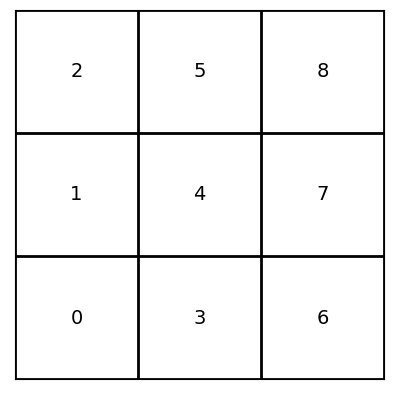

In [35]:
draw_pitch_tessellation()

##### Case 1

In [19]:
decoded_indices = np.argmax(X_test[2], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[5 5 5 5 5 2]


In [20]:
decoded_indices = np.argmax(y_test[2], axis=0)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[1]


In [21]:
# in case you are using the loaded model, execute this line, otherwise change the 'predict' method into 'predict_proba'
predictions = model.predict(np.expand_dims(X_test[2], axis=0))
predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 1s 644ms/step


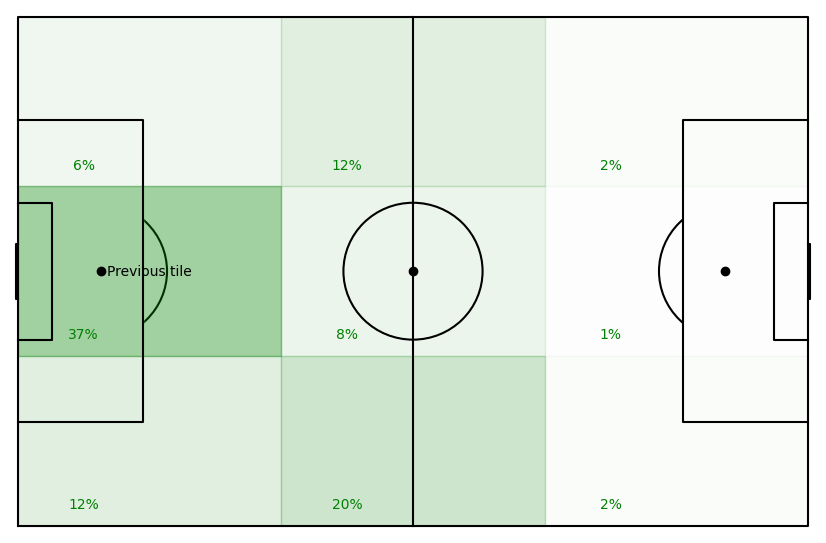

In [22]:
draw_pitch("white", "black", prob, decoded_indices[-1])

##### Case 2

In [23]:
decoded_indices = np.argmax(X_test[9], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[0 3 3 3 0 1 2 5 2 2 1 3]


In [24]:
# Find the index of the maximum value in each one-hot encoded vector (representing the original class)
decoded_indices = np.argmax(y_test[9], axis=0)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[3]


In [25]:
predictions = model.predict(np.expand_dims(X_test[9], axis=0))
predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 0s 45ms/step


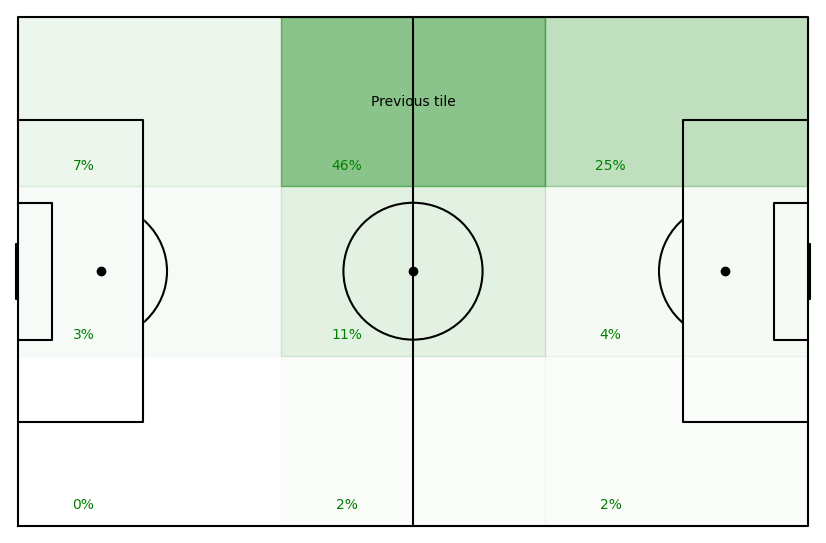

In [26]:
draw_pitch("white", "black", prob, decoded_indices[-1])

##### Case 3

In [27]:
decoded_indices = np.argmax(X_test[26], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[4 3 6 3]


In [28]:
# Find the index of the maximum value in each one-hot encoded vector (representing the original class)
decoded_indices = np.argmax(y_test[26], axis=0)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[6]


In [29]:
predictions = model.predict(np.expand_dims(X_test[26], axis=0))
predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 0s 45ms/step


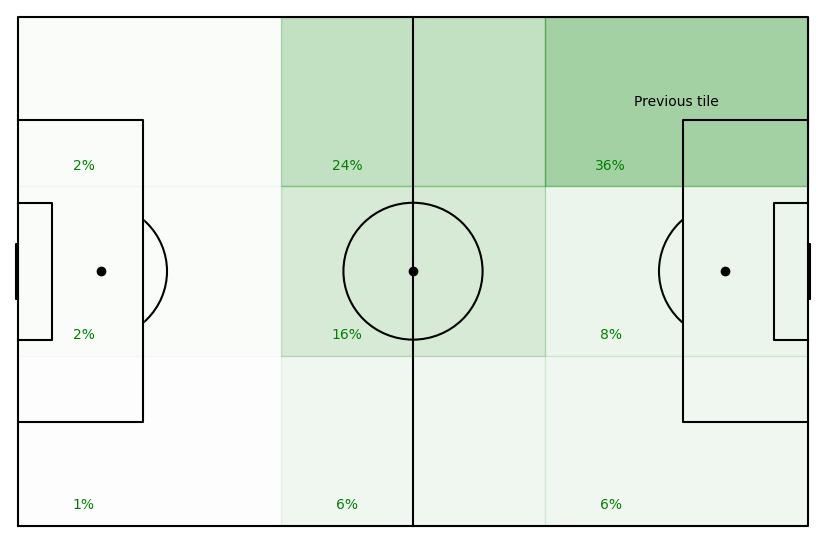

In [30]:
draw_pitch("white", "black", prob, decoded_indices[-1])

##### Case 4

In [31]:
decoded_indices = np.argmax(X_test[45], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[0 5 1 4 2 5 5 3 7]


In [32]:
# Find the index of the maximum value in each one-hot encoded vector (representing the original class)
decoded_indices = np.argmax(y_test[45], axis=0)

decoded_indices = decoded_indices[decoded_indices != 9]
print(decoded_indices)

[7]


In [33]:
predictions = model.predict(np.expand_dims(X_test[45], axis=0))
predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 0s 40ms/step


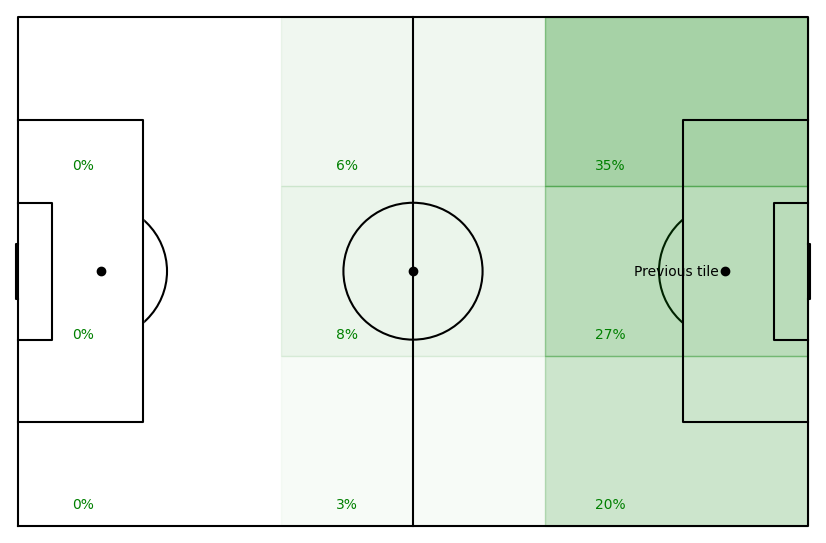

In [34]:
draw_pitch("white", "black", prob, decoded_indices[-1])